In [1]:
import numpy as np
import PyPDF2
import pandas as pd
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from gensim.models import Word2Vec, Phrases

from modules.TextCleaner import Cleaner
from modules.Networks import Embedder
from modules.HelperFunctions import Helper

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load in medicine wiki page
num_pages = 16
file = open('data/Medicine.pdf', 'rb')
fileReader = PyPDF2.PdfFileReader(file)
print(f'num pages: {min([fileReader.numPages, num_pages])}')
text = ''
for i in range(0, min([fileReader.numPages, num_pages])):
    text += fileReader.pages[i].extract_text()

num pages: 16


In [3]:
# clean text
save = True
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 
            'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 
            'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 
            'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 
            'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 
            'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 
            'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 
            'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 
            'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 
            'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 
            'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 
            'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 
            't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 
            'further', 'was', 'here', 'than', 'also', '%', '-', 'may', '–', 'e'] 

cleaner = Cleaner(stop_words=stop_words)
sentences, ngram_count = cleaner.get_sentences(text, save)

... cleaning text ...

... splitting into sentences ...

number of sentences extracted: 345


In [4]:
# create binary vecs for softmax prediction of context words
helper = Helper(w_size=2,
                emb_size=2,
                num_neg_samples=0,
                total_sentences=600,
                min_count = 1)
samples, ngram_count = helper.get_samples(sentences)

num sentences: 323
vocab size: 696
num samples: 2998


In [16]:
# train network to create embeddings
torch.manual_seed(200206323)
max_epochs = 6
batch_size = 20
criterion = nn.MSELoss()
embedder = Embedder(emb_size=2, vocab_size=int(samples.shape[1] / 2))
optimizer = torch.optim.Adam(embedder.parameters(), lr=0.003, weight_decay=0.0000001)
trainloader = torch.utils.data.DataLoader(samples, batch_size=batch_size, shuffle=True)
running_loss = 0
for epoch in range(max_epochs):
    for batch in trainloader:
        x_batch = batch[:, 0:len(list(ngram_count.keys()))]
        y_batch = batch[:, len(list(ngram_count.keys())):]
        optimizer.zero_grad()
        estimate = embedder(x_batch.clone().detach().requires_grad_(True).float())
        loss = criterion(estimate, y_batch.clone().detach().requires_grad_(True).float())
        loss.backward()
        optimizer.step()
        loss = loss.item()
        running_loss += loss
    if epoch % 5 == 0 and epoch > 0:
        ave_loss = round(running_loss / (20 * (samples.shape[0] / batch_size)), 6)
        print(f'Average loss per text at epoch number {epoch} : {ave_loss}')
        running_loss = 0

Average loss per text at epoch number 5 : 0.001376


In [17]:
# extract embeddings from network
for i, param in enumerate(embedder.parameters()):
    if i == 2:
        embeddings = param.detach().numpy()
embeddings_df = pd.DataFrame(data=embeddings, index=list(ngram_count.keys()))

In [18]:
# get cosine distances
cosine_dist_dict = helper.get_cosine_dist(embeddings_df, list(ngram_count.keys()))

In [19]:
# view most used words in text
print(np.array(list((ngram_count.keys())))[np.argsort(list((ngram_count.values())))][-100:])

['new' 'evidence' 'specific' 'technology' 'professional' 'although'
 'specialty' 'research' 'sciences' 'organ' 'main' 'interdisciplinary'
 'surgeons' 'human' 'fields' 'problems' 'healthcare' 'treat' 'middle'
 'western' 'require' 'diagnostic' 'college' 'pathology' 'disorders'
 'related' 'school' 'laboratory' 'physical' 'legal' 'europe' 'ledge'
 'values' 'internal' 'united' 'unde' 'development' 'generally' 'ethics'
 'doctor' 'prevention' 'apply' 'greek' 'states' 'family' 'tests' 'primary'
 'early' 'work' 'function' 'delivery' 'emergency' 'called' 'countries'
 'education' 'body' 'diagnosis' 'ancient' 'deals' 'hospital' 'residency'
 'example' 'often' 'world' 'used' 'systems' 'know' 'examination' 'science'
 'including' 'diseases' 'first' 'specialties' 'subspecialties' 'hospitals'
 'one' 'modern' 'services' 'include' 'training' 'general' 'disease'
 'system' 'concerned' 'many' 'clinical' 'physician' 'physicians' 'history'
 'patients' 'surgical' 'treatment' 'patient' 'practice' 'study' 'surger

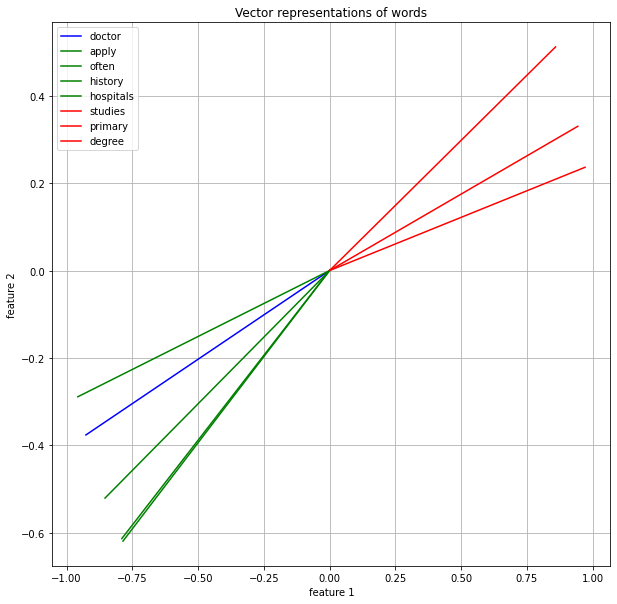

In [27]:
# visualise 2D ngram embeddings
num_embs = 3
ngram_choice = 'doctor'
helper.plot_embs(embeddings_df, cosine_dist_dict, num_embs=num_embs, ngram_choice=ngram_choice)